In [25]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [104]:
# File paths
Cleanfile = r"/Users/livalacaisse/Documents/DataScience/CO2/000-C02 First Delivery/Cleaned_countries/FR_Cleaned.csv"


# Data types specification
dtype_spec = {
    'Em_on_target': 'int64',
    'Fuel consumption': 'float32',
    'Engine_cm3': 'float32',
    'Kg_veh': 'float32',
    'Test_mass': 'float32',
    'Power_KW': 'float32',
    'El_Consumpt_whkm': 'float32',
    'Energy': 'category',
    'Fuel_mode': 'category',
    'Brand': 'category',
    'Veh_type': 'category',
    'Veh_Model': 'category',
    'Version': 'category',
    'Veh_Category': 'category',
    'year': 'int64',
    'Country': 'category'
}

# Load data
df_clean = pd.read_csv(Cleanfile, dtype=dtype_spec, low_memory=False)
drop =["Unnamed: 0","Em_on_target"]
df_clean = df_clean.drop(drop, axis=1)

df_clean.drop_duplicates(inplace=True)

In [105]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 651068 entries, 0 to 9609015
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Country                 651068 non-null  category
 1   Constructor             651068 non-null  object  
 2   Veh_type                651068 non-null  category
 3   Version                 651068 non-null  category
 4   Brand                   651068 non-null  category
 5   Veh_Model               651068 non-null  category
 6   Veh_Category            651068 non-null  category
 7   Kg_veh                  651068 non-null  float32 
 8   Test_mass               651068 non-null  float32 
 9   CO2_wltp                651068 non-null  float64 
 10  Wheelbase_mm            651068 non-null  float64 
 11  Axle_width_steer_mm     651068 non-null  float64 
 12  Axle_width_other_mm     651068 non-null  float64 
 13  Energy                  651068 non-null  category
 14  Fuel_mod

In [106]:
# Encode categorical variables
#label_encoders = {}
#for column in df_clean.select_dtypes(include=['category']).columns:
    #label_encoders[column] = LabelEncoder()
    #df_clean[column] = label_encoders[column].fit_transform(df_clean[column])

# Display the first few rows to verify
#df_clean.head()

In [107]:
# Define the features for each energy type
features_dict = {
    'petrol': ['Fuel consumption', 'Wheelbase_mm', 'Engine_cm3', 'Power_KW', 'Axle_width_steer_mm', 
               'Test_mass', 'Axle_width_other_mm', 'Eco-innovation program', 'Kg_veh', 'year', 
               'Erwltp (g/km)', 'El_Consumpt_whkm'],
    'diesel': ['Wheelbase_mm', 'Axle_width_other_mm', 'Power_KW', 'Test_mass', 'Axle_width_steer_mm', 
               'Kg_veh', 'Engine_cm3', 'Fuel consumption', 'year', 'Erwltp (g/km)', 'Eco-innovation program', 
               'El_Consumpt_whkm'],
    'lpg': ['Kg_veh', 'Fuel consumption', 'Axle_width_steer_mm', 'Axle_width_other_mm', 'year', 'Test_mass', 
            'Power_KW', 'Erwltp (g/km)', 'Engine_cm3', 'Wheelbase_mm', 'Eco-innovation program', 
            'Electric range (km)'],
    'hybrid petrol': ['Engine_cm3', 'Axle_width_other_mm', 'Axle_width_steer_mm', 'Fuel consumption', 
                     'El_Consumpt_whkm', 'Power_KW', 'Electric range (km)', 'year', 'Wheelbase_mm', 
                     'Eco-innovation program', 'Test_mass', 'Kg_veh'],
    'hybrid diesel': ['El_Consumpt_whkm', 'Axle_width_other_mm', 'Electric range (km)', 'Axle_width_steer_mm', 
                     'year', 'Kg_veh', 'Test_mass', 'Fuel consumption', 'Wheelbase_mm', 'Eco-innovation program', 
                     'Erwltp (g/km)', 'Power_KW']
}

In [130]:
# Function to prepare data for regression
def prepare_data(df, energy_types, features_dict):
    if isinstance(energy_types, list):
        dfs = []
        for energy in energy_types:
            df_energy = df[df['Energy'] == energy].copy()
            if df_energy.empty:
                print(f"No data for energy type: {energy}")
                continue
            df_energy = df_energy[features_dict[energy] + ['CO2_wltp']]
            dfs.append(df_energy)
        if not dfs:
            return pd.DataFrame(), pd.Series(), []
        df_combined = pd.concat(dfs, axis=0)
        features = [feat for energy in energy_types for feat in features_dict[energy]]
        features = list(set(features))  # Remove duplicates
    else:
        df_combined = df[df['Energy'] == energy_types].copy()
        if df_combined.empty:
            print(f"No data for energy type: {energy_types}")
            return pd.DataFrame(), pd.Series(), []
        features = features_dict[energy_types]
    
    X = df_combined[features]
    y = df_combined['CO2_wltp']
    
    return X, y, features


In [137]:
# Ridge Regression function with fixed alpha and enhanced visualization
def ridge_regression(df, energy_types, features_dict, alpha=10):
    # Prepare data
    X, y, feature_names = prepare_data(df, energy_types, features_dict)
    
    if X.empty or y.empty:
        print(f"No data available for energy types: {energy_types}")
        return None, None, None
    
    # Handle missing values
    X = X.fillna(X.mean())  # Avoid SettingWithCopyWarning
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Dimensionality Reduction
    pca = PCA(n_components=0.95)  # Keep 95% of variance
    X_pca = pca.fit_transform(X_scaled)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
    
    # Ridge Regression with fixed alpha
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    
    # Cross-validation score
    cv_scores = cross_val_score(ridge, X_train, y_train, cv=5)
    
    # Predictions
    y_pred = ridge.predict(X_test)
    
    # Evaluation
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    # Results reporting
    print(f"Energy Type: {'All' if isinstance(energy_types, list) else energy_types}")
    print(f"Alpha: {alpha}")
    print(f"R^2 Score: {r2}")
    print(f"Mean Squared Error: {mse}")
    print(f"Cross-Validation Scores: {cv_scores}")
    print(f"Mean CV Score: {np.mean(cv_scores)}")
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    
    # Scatter plot of actual vs predicted
    sns.scatterplot(x=y_test, y=y_pred, ax=axes[0])
    axes[0].set_xlabel('Actual CO2_wltp')
    axes[0].set_ylabel('Predicted CO2_wltp')
    axes[0].set_title(f'Regression Results for {"All Energies" if isinstance(energy_types, list) else energy_types}')
    
    # Feature coefficients plot
    coef = ridge.coef_
    original_feature_importances = np.dot(pca.components_.T, coef)
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.abs(original_feature_importances)})
    coef_df = coef_df.sort_values(by='Coefficient', ascending=False)
    
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, ax=axes[1])
    axes[1].axvline(x=0, color='red', linestyle='--')
    axes[1].set_title('Feature Coefficients')
    
    plt.tight_layout()
    plt.show()
    
    # Print feature importance
    print("Feature Importances:")
    for feature, coef in zip(feature_names, original_feature_importances):
        print(f"{feature}: {coef}")
    
    return ridge, r2, mse



Energy Type: petrol
Alpha: 10
R^2 Score: 0.6281734403585676
Mean Squared Error: 128.76127910968458
Cross-Validation Scores: [0.62704648 0.6279744  0.62800429 0.62718565 0.6299433 ]
Mean CV Score: 0.6280308248151203


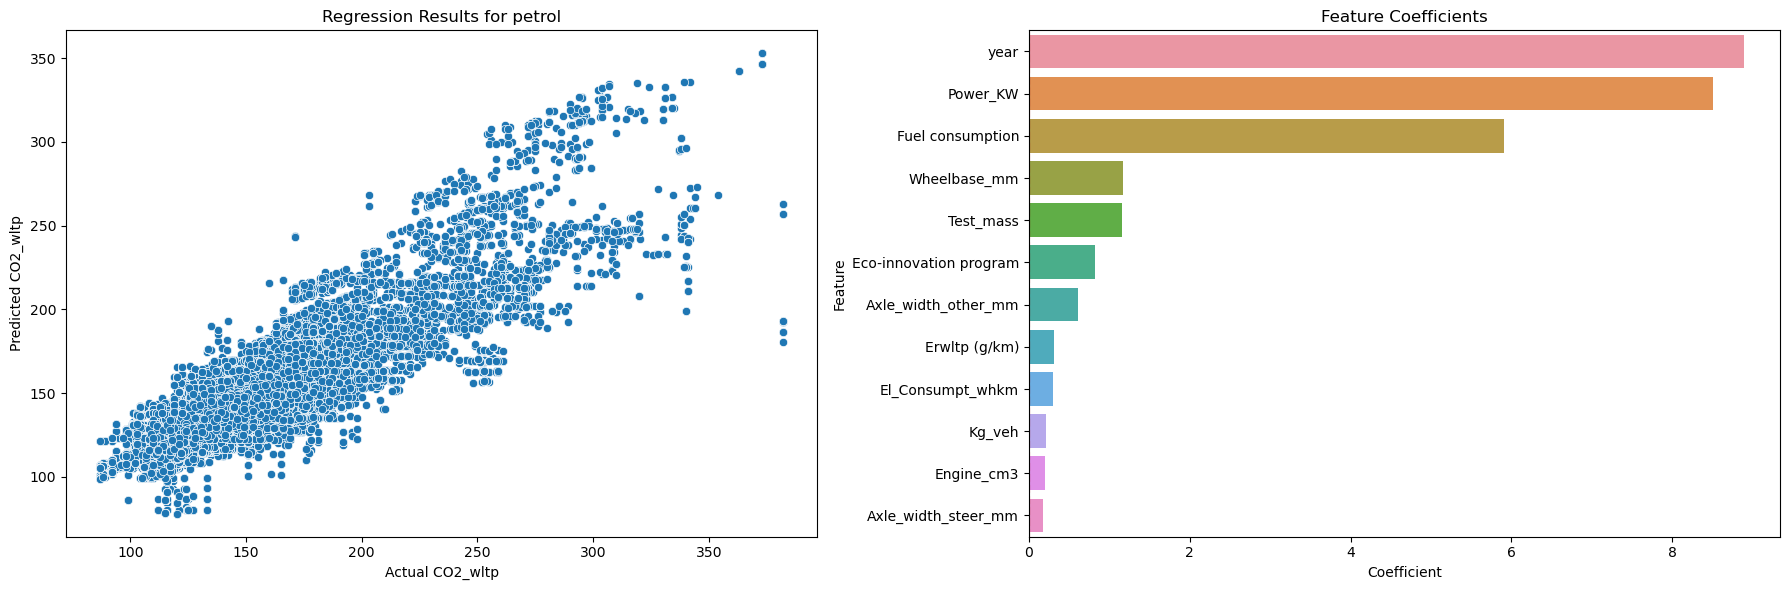

Feature Importances:
Fuel consumption: 5.9026302857757065
Wheelbase_mm: 1.1715650502524944
Engine_cm3: -0.20043180103648073
Power_KW: 8.501745559228118
Axle_width_steer_mm: 0.1772217216371359
Test_mass: 1.1586567268124892
Axle_width_other_mm: 0.6169060476401027
Eco-innovation program: 0.8282262127201352
Kg_veh: 0.20942628926365936
year: -8.895798610195225
Erwltp (g/km): 0.30695331671312465
El_Consumpt_whkm: -0.29713397525786994
Energy Type: diesel
Alpha: 10
R^2 Score: 0.7961175700932333
Mean Squared Error: 94.86905900618952
Cross-Validation Scores: [0.79786202 0.79605603 0.79538404 0.79729953 0.79644627]
Mean CV Score: 0.7966095790351719


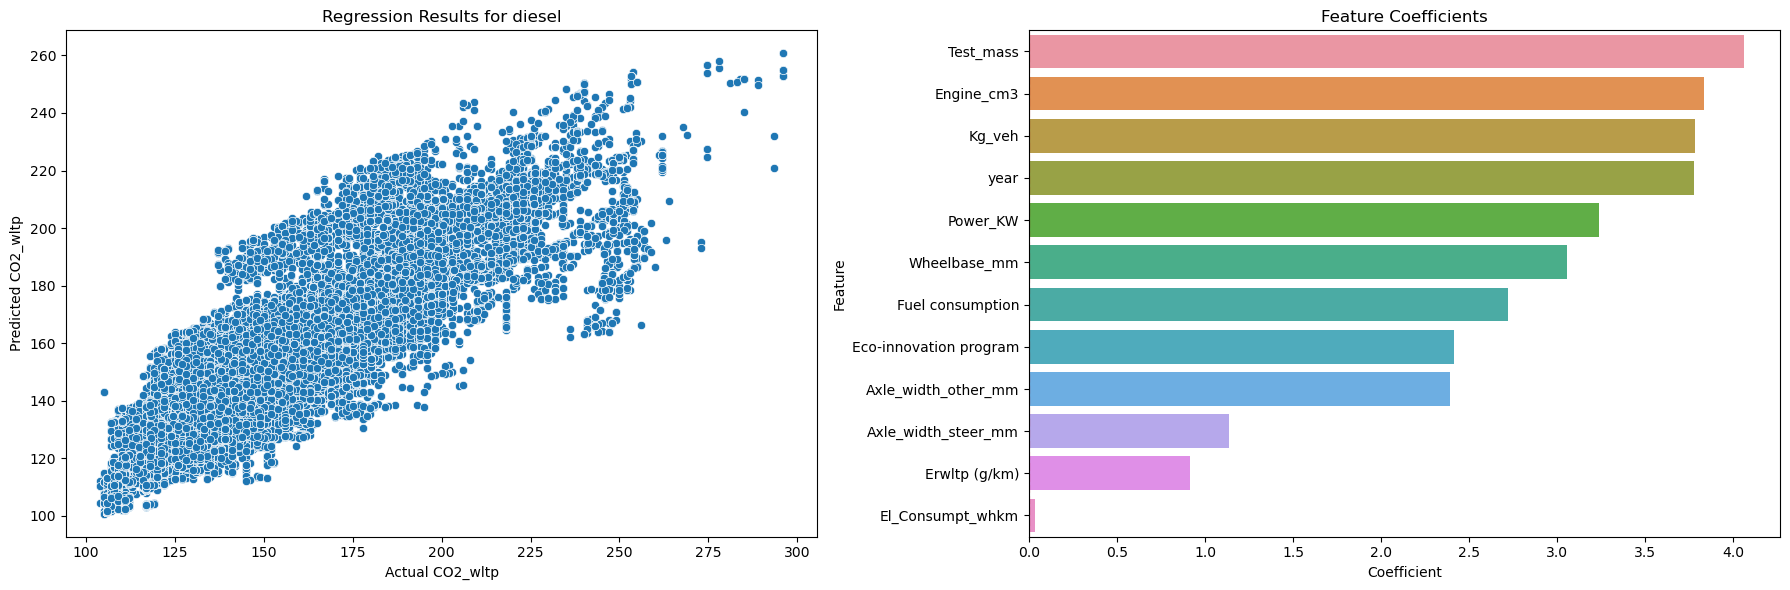

Feature Importances:
Wheelbase_mm: 3.0527613640346507
Axle_width_other_mm: 2.3888112252573865
Power_KW: 3.235388391171937
Test_mass: 4.061010107026869
Axle_width_steer_mm: 1.1360346396150962
Kg_veh: 3.78116720885806
Engine_cm3: 3.833710259061185
Fuel consumption: 2.7225844074402294
year: -3.7764332641257954
Erwltp (g/km): 0.9133601983218451
Eco-innovation program: -2.4134732694852477
El_Consumpt_whkm: 0.034849078191112874
Energy Type: lpg
Alpha: 10
R^2 Score: 0.7695757223287737
Mean Squared Error: 16.414577530475857
Cross-Validation Scores: [0.78038512 0.77223105 0.76061709 0.77575702 0.76824761]
Mean CV Score: 0.7714475747970988


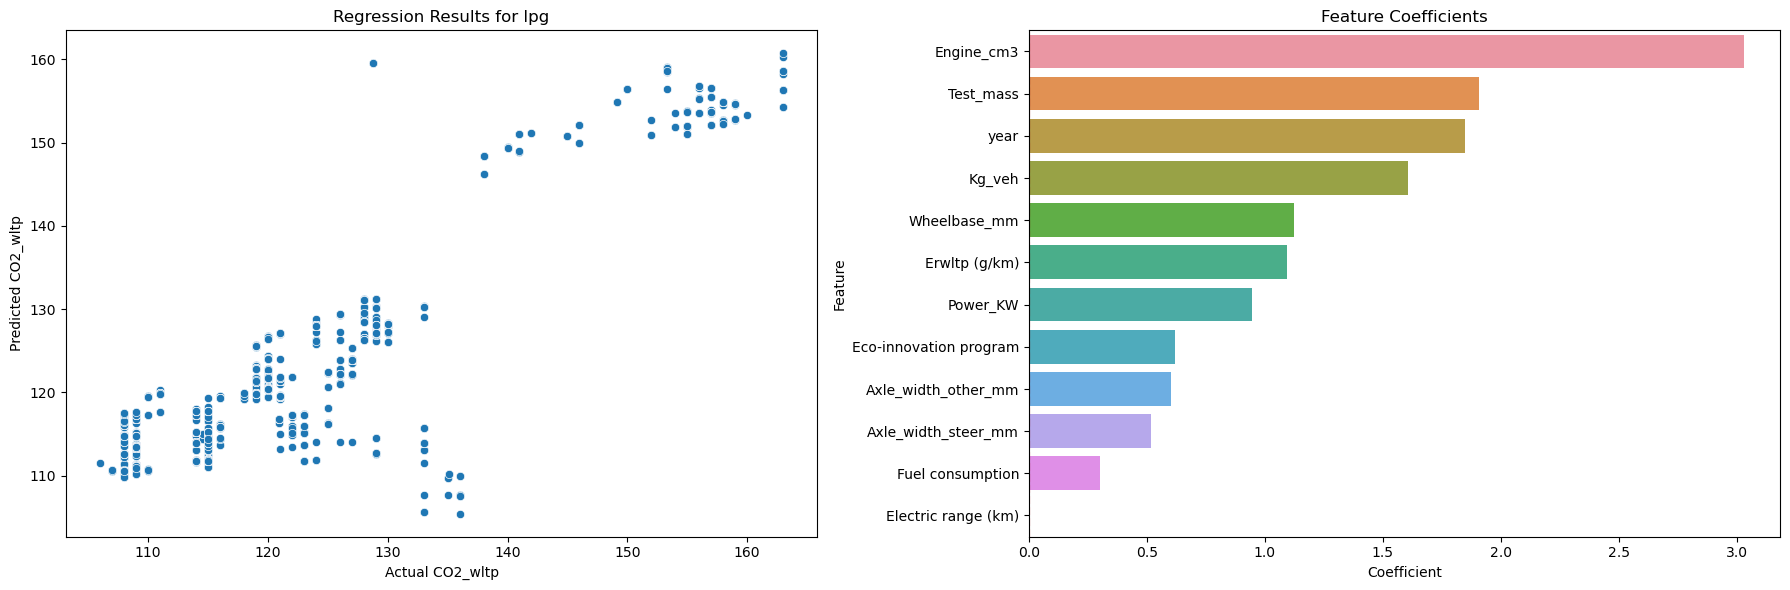

Feature Importances:
Kg_veh: 1.607714236146568
Fuel consumption: 0.2999199804289443
Axle_width_steer_mm: 0.5162822447072657
Axle_width_other_mm: 0.6006707173497181
year: -1.847594507028694
Test_mass: 1.9075342346338018
Power_KW: 0.9477860946565748
Erwltp (g/km): -1.092801415077089
Engine_cm3: 3.0317057356256227
Wheelbase_mm: 1.121639129786952
Eco-innovation program: -0.6211849591769502
Electric range (km): 0.0
Energy Type: hybrid petrol
Alpha: 10
R^2 Score: 0.3769905230973023
Mean Squared Error: 187.23189197251307
Cross-Validation Scores: [0.37009435 0.37485821 0.37684865 0.37811305 0.37735861]
Mean CV Score: 0.37545457581533936


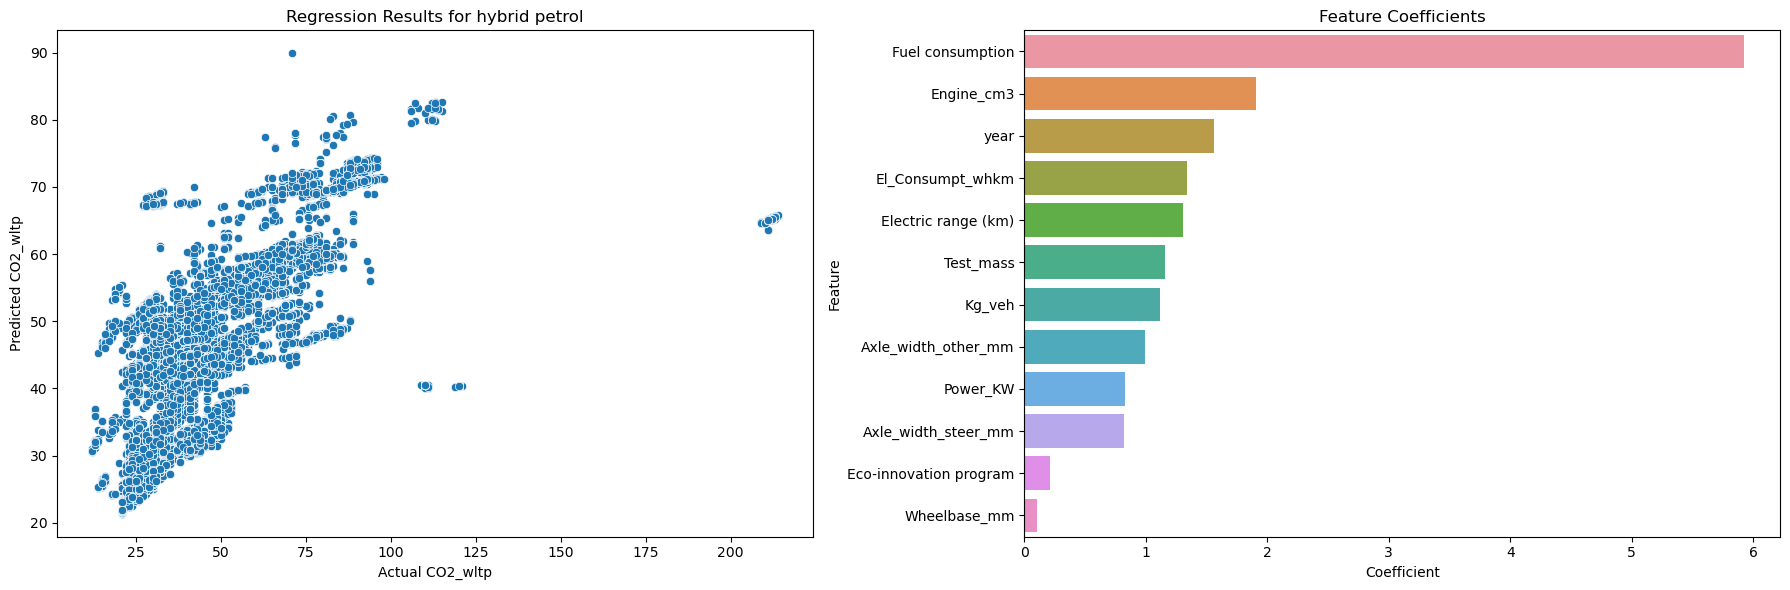

Feature Importances:
Engine_cm3: 1.9048925788353803
Axle_width_other_mm: 0.9906076476100081
Axle_width_steer_mm: 0.8202758804064805
Fuel consumption: 5.9233370578904445
El_Consumpt_whkm: 1.33878360191855
Power_KW: 0.8315141748562871
Electric range (km): -1.3036715732831587
year: -1.5604175793455894
Wheelbase_mm: 0.09978572949661024
Eco-innovation program: -0.2129720064798618
Test_mass: 1.1586102366072364
Kg_veh: 1.1134710335542948
Energy Type: hybrid diesel
Alpha: 10
R^2 Score: 0.9141649567946013
Mean Squared Error: 15.07623303370186
Cross-Validation Scores: [0.91234626 0.91424068 0.90827982 0.91280725 0.91878437]
Mean CV Score: 0.9132916758397016


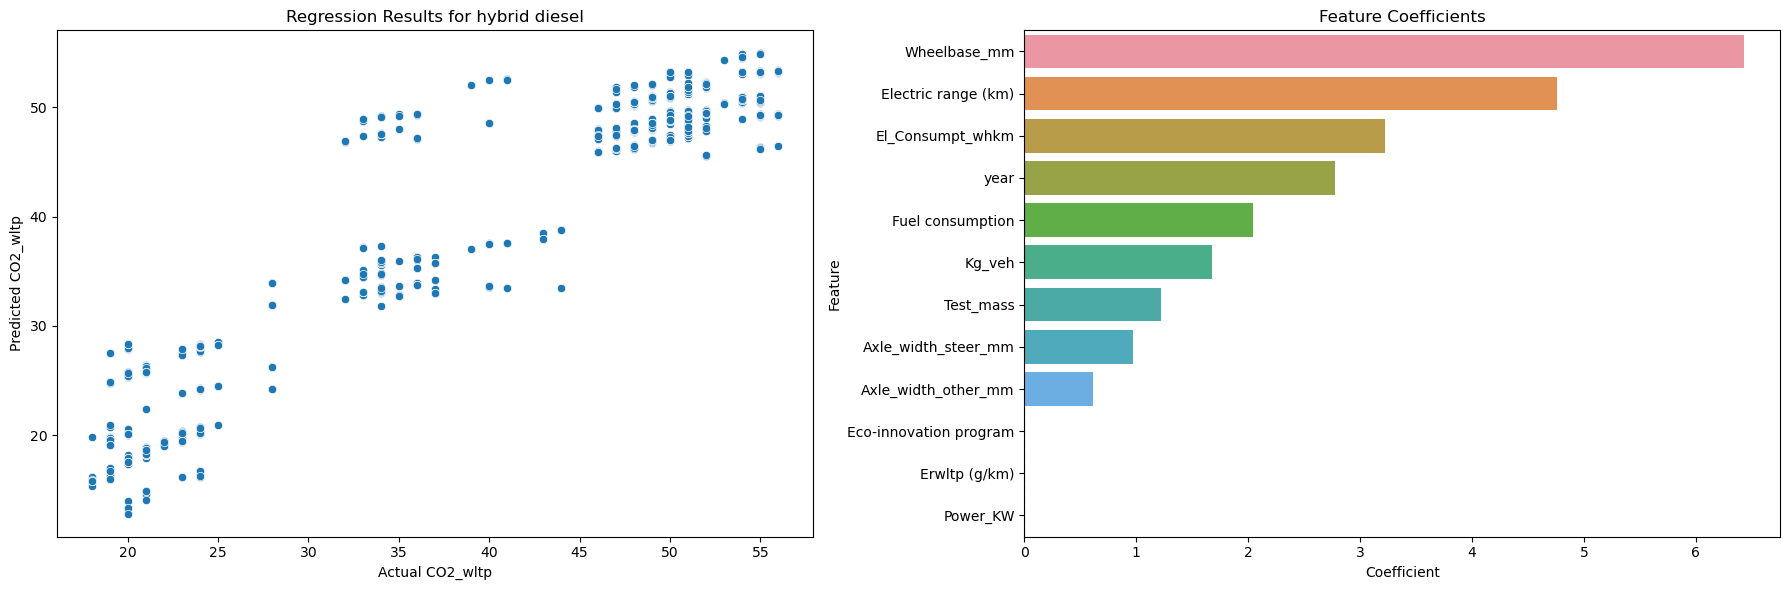

Feature Importances:
El_Consumpt_whkm: 3.224258835572909
Axle_width_other_mm: 0.6114637320671357
Electric range (km): -4.7631690551496115
Axle_width_steer_mm: -0.9714718644627571
year: 2.778404632192582
Kg_veh: -1.6780468383748262
Test_mass: -1.223323523521879
Fuel consumption: 2.0386625646732606
Wheelbase_mm: -6.431078727813451
Eco-innovation program: 0.0
Erwltp (g/km): 0.0
Power_KW: 0.0


In [138]:
# Apply Ridge Regression for each energy type and all together with enhanced visualization
results = {}
for energy, features in features_dict.items():
    results[energy] = ridge_regression(df_Clean, energy, features_dict)

Energy Type: All
Alpha: 10
R^2 Score: 0.7156168395951601
Mean Squared Error: 212.87971078139947
Cross-Validation Scores: [0.71489859 0.71591931 0.71553291 0.71633613 0.71464461]
Mean CV Score: 0.7154663102849812


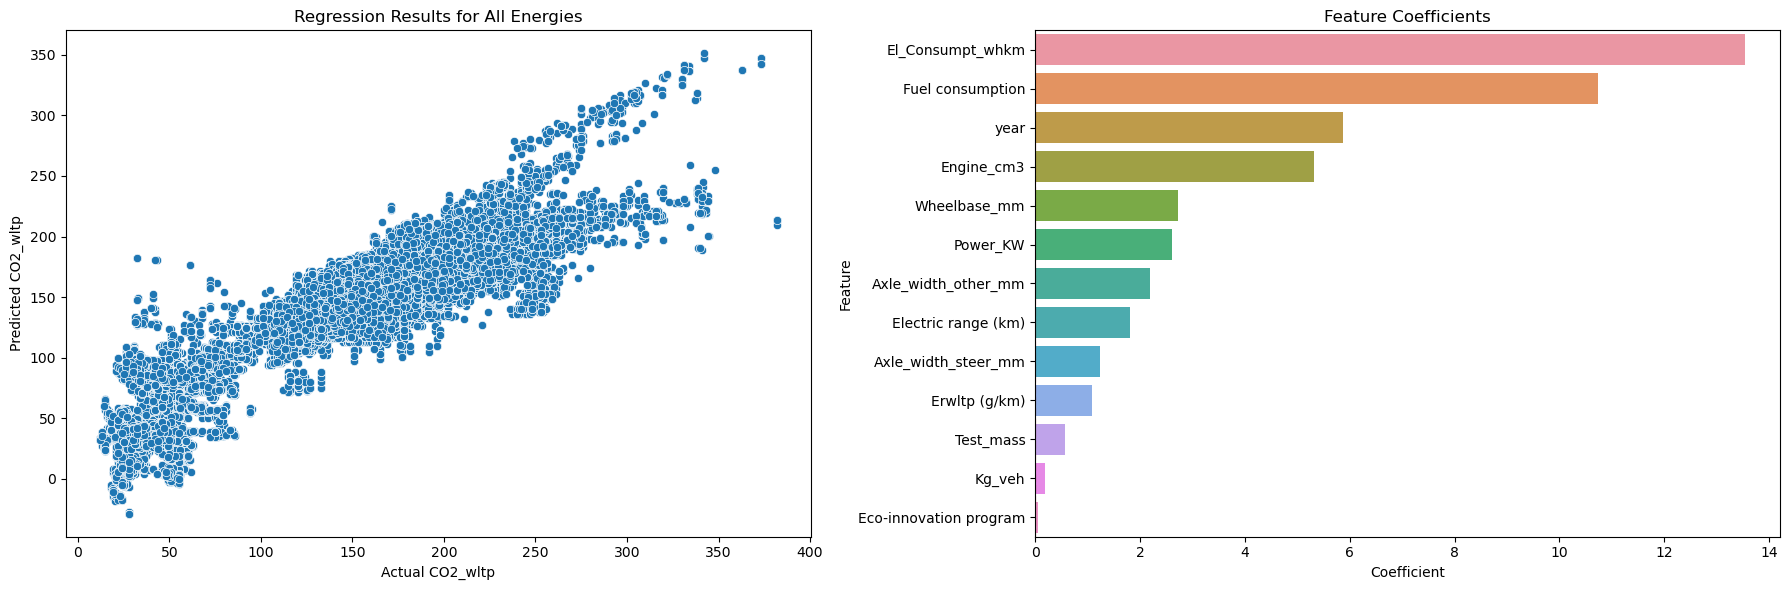

Feature Importances:
Test_mass: 0.5792296823866301
Axle_width_steer_mm: 1.235841943642071
El_Consumpt_whkm: -13.530119262814578
Kg_veh: -0.18155074887992773
Axle_width_other_mm: 2.1962893289257885
Erwltp (g/km): -1.0790628186014875
Power_KW: 2.6026872716328806
Electric range (km): 1.8067566251019882
Fuel consumption: 10.734989197329615
year: -5.864782422920147
Wheelbase_mm: 2.727402513936182
Eco-innovation program: -0.06166067108360587
Engine_cm3: 5.315449657178296


In [140]:
# Run regression on all energies together
all_energies = list(features_dict.keys())
results['all_energies'] = ridge_regression(df_Clean, all_energies, features_dict)